In [ ]:
import scvi
import scanpy as sc
import os
import numpy as np
from matplotlib.pyplot import rc_context
import pandas as pd

/home/ciardha/anaconda3/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ciardha/anaconda3/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
2024-06-21 12:50:31,922	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-21 12:50:32,142	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Note: preprocessing should be improved in real use case. Very basic preprocessing below

# dedifferentiation data

In [ ]:
# Define the directory path
directory = '/Users/jinf/PhD_project/project_UCD_blca/blca_DATA/blca_DATA_mouse_GSE174182_RAW'
# Get the list of files in the directory (non-recursive)
dirs = os.listdir(directory)

# Create an empty list to store the names
names_list = []

# Extract the unique names from the first 20 characters of the filenames
for x in dirs:
    name = x[:20]
    names_list.append(name)

# Remove duplicates by converting to a set and then back to a list
names_list = list(set(names_list))

# Print the unique names
print(names_list)


In [3]:
names_list=['GSM5288669_Sample-4_', 'GSM5288670_Sample-5_', 'GSM5288671_Sample-6_', 
            'GSM5288668_Sample-3_', 'GSM5288672_Sample-7_', 'GSM5288673_Sample-8_', 'GSM5288674_Sample-11']

In [ ]:
os.chdir(directory)

In [61]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:

    mtx =f"{name}filtered_matrix.mtx.gz"
    adata = sc.read_mtx(mtx)
    cells=pd.read_csv(f'{name}filtered_barcodes.tsv.gz',header=None)
    features=pd.read_csv(f'{name}filtered_features.tsv.gz',header=None,sep='\t')
    adata= adata.T
    #check the columns first to make sure they are the ones you need 
    adata.obs['CellID']= cells[0].tolist()
    adata.var['Gene']= features[1].tolist()
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 

    sc.pp.filter_cells(adata, min_genes=300)
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .97)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]

    adata.raw = adata  # keep full dimension safe
    sc.pp.highly_variable_genes(
        adata,
        flavor="seurat_v3",
        n_top_genes=2000,
        layer="counts",
        batch_key="batch",
        subset=True,)


    adata.obs['source'] = name[:10]

    adata_list.append(adata)

In [38]:
adata = sc.concat(datas, index_unique = '_')

In [39]:
sc.pp.filter_genes(adata, min_cells = 100)

adata.layers['counts'] = adata.X.copy()

scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['total_counts'])


model = scvi.model.SCVI(adata)

In [47]:
model.train() 

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 89/89: 100%|██████| 89/89 [22:05<00:00, 14.90s/it, loss=7.05e+03, v_num=1]


In [48]:
adata.obsm['X_scVI'] = model.get_latent_representation()

adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

sc.pp.neighbors(adata, use_rep = 'X_scVI')

sc.tl.umap(adata)

In [63]:
adata.obs['Day'] = adata.obs.Sample.map(days)

In [64]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,Day,Sample,_scvi_batch,_scvi_labels
AAACCTGGTAAATGTG-1_0,2881,2881,10097.0,11.5,GSM3195714,0,0
AAACGGGCAGACGCAA-1_0,5107,5107,35162.0,11.5,GSM3195714,0,0
AAAGATGCAACAACCT-1_0,3472,3472,20262.0,11.5,GSM3195714,0,0
AAAGATGCACGAAAGC-1_0,2073,2073,5480.0,11.5,GSM3195714,0,0
AAAGATGTCTCAAGTG-1_0,1713,1713,6286.0,11.5,GSM3195714,0,0
...,...,...,...,...,...,...,...
TTTGGTTTCGTTGCCT-1_39,2184,2184,7659.0,8.0,GSM3195680,0,0
TTTGTCAAGGCACATG-1_39,2626,2626,12497.0,8.0,GSM3195680,0,0
TTTGTCAAGGCTAGGT-1_39,1694,1694,6577.0,8.0,GSM3195680,0,0
TTTGTCATCAAGATCC-1_39,1634,1634,5856.0,8.0,GSM3195680,0,0


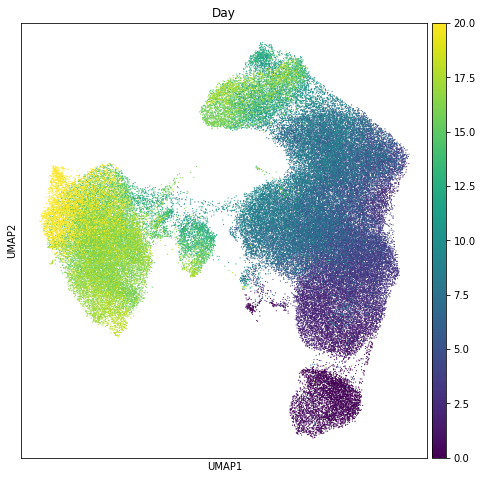

In [72]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color = 'Day', s = 5)

In [74]:
adata.write_h5ad('data_saved/scvi_dedif.h5ad')

# CD16 removed

In [1]:
import scvi
import scanpy as sc
import os
import numpy as np
from matplotlib.pyplot import rc_context

Global seed set to 0


In [3]:
dirs = os.listdir('pbmc_cd16/')
dirs = [x for x in dirs if 'csv' not in x]
dirs

['MH8919332',
 'MH8919178',
 'MH8919283',
 'MH8919333',
 'MH8919179',
 'MH8919177',
 'MH8919227',
 'MH8919176',
 'MH8919282',
 'MH8919226',
 'newcastle65',
 'newcastle74']

In [102]:
def pp(path):
    adata = sc.read_10x_mtx(path)
    
    sc.pp.filter_cells(adata, min_genes=300)
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .97)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    
    
    adata.obs['Sample'] = path.split('/')[1]
    
    return adata

In [7]:
datas = [pp('pbmc_cd16/' + x) for x in dirs]

/tmp/ipykernel_9832/2414022266.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Sample'] = path.split('/')[1]
/tmp/ipykernel_9832/2414022266.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Sample'] = path.split('/')[1]
/tmp/ipykernel_9832/2414022266.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Sample'] = path.split('/')[1]
/tmp/ipykernel_9832/2414022266.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Sample'] = path.split('/')[1]
/tmp/ipykernel_9832/2414022266.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Sample'] = path.split('/')[1]
/tmp/ipykernel_9832/2414022266.py:10: ImplicitModificationWarning: Trying to modify attrib

In [9]:
adata = sc.concat(datas)

In [10]:
adata

AnnData object with n_obs × n_vars = 61728 × 24929
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'Sample'

In [11]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,Sample
AAACCTGAGACAGAGA-MH8919332,997,997,3796.0,MH8919332
AAACCTGAGAGAGCTC-MH8919332,1124,1124,3439.0,MH8919332
AAACCTGAGCAGGTCA-MH8919332,901,901,3550.0,MH8919332
AAACCTGAGCTCCTTC-MH8919332,1966,1966,8749.0,MH8919332
AAACCTGAGTCAAGGC-MH8919332,1057,1057,3985.0,MH8919332
...,...,...,...,...
TTTGTCAGTAGCTAAA-newcastle74,1451,1451,3687.0,newcastle74
TTTGTCATCATGTAGC-newcastle74,1633,1633,5181.0,newcastle74
TTTGTCATCTCAAGTG-newcastle74,1532,1532,4672.0,newcastle74
TTTGTCATCTTCAACT-newcastle74,1273,1273,2903.0,newcastle74


In [12]:
sc.pp.filter_genes(adata, min_cells = 100)

adata.layers['counts'] = adata.X.copy()

scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['total_counts'])


model = scvi.model.SCVI(adata)

adfsdfsdf
adfsdfsdf


In [13]:
model.train() 

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 130/130: 100%|██| 130/130 [19:06<00:00,  8.82s/it, loss=4.34e+03, v_num=1]


In [14]:
adata.obsm['X_scVI'] = model.get_latent_representation()

adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

sc.pp.neighbors(adata, use_rep = 'X_scVI')

sc.tl.umap(adata)

In [20]:
cells = pd.read_csv('pbmc_cd16/cell_types.csv')
cells = dict(zip(cells.covid_index, cells.initial_clustering))

adata.obs['cell_type'] = adata.obs.index.map(cells)

In [21]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,Sample,_scvi_batch,_scvi_labels,cell_type
AAACCTGAGACAGAGA-MH8919332,997,997,3796.0,MH8919332,0,0,CD8
AAACCTGAGAGAGCTC-MH8919332,1124,1124,3439.0,MH8919332,0,0,CD8
AAACCTGAGCAGGTCA-MH8919332,901,901,3550.0,MH8919332,0,0,CD8
AAACCTGAGCTCCTTC-MH8919332,1966,1966,8749.0,MH8919332,0,0,CD14
AAACCTGAGTCAAGGC-MH8919332,1057,1057,3985.0,MH8919332,0,0,CD8
...,...,...,...,...,...,...,...
TTTGTCAGTAGCTAAA-newcastle74,1451,1451,3687.0,newcastle74,0,0,CD8
TTTGTCATCATGTAGC-newcastle74,1633,1633,5181.0,newcastle74,0,0,CD4
TTTGTCATCTCAAGTG-newcastle74,1532,1532,4672.0,newcastle74,0,0,CD8
TTTGTCATCTTCAACT-newcastle74,1273,1273,2903.0,newcastle74,0,0,NK_16hi


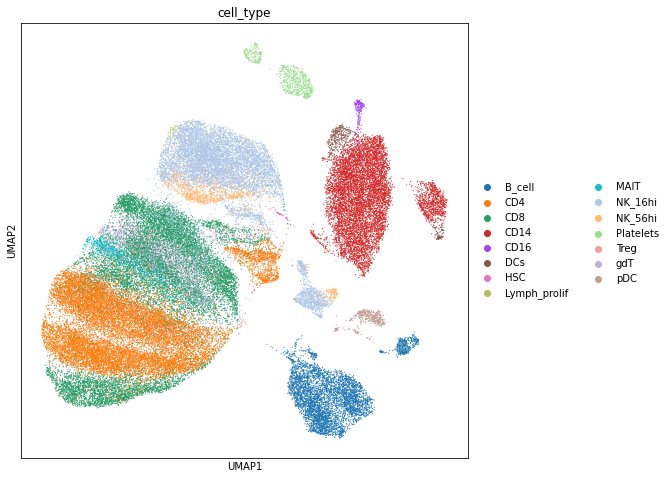

In [22]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color = 'cell_type', s = 5)

In [23]:
adata.write_h5ad('data_saved/scvi_cd16.h5ad')